In [17]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r'C:\Users\tusha\Documents\My Project\New folder\online_retail_II.xlsx'
df = pd.read_excel(file_path)

df['Customer ID'] = df['Customer ID'].astype('Int64')

print("Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Shape: (1048575, 8)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95        13085  United Kingdom  
1 2009-12-01 07:45:00   6.75        13085  United Kingdom  
2 2009-12-01 07:45:00   6.75        13085  United Kingdom  
3 2009-12-01 07:45:00   2.10        13085  United Kingdom  
4 2009-12-01 07:45:00   1.25        13085  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    

In [18]:

import pandas.api.types as pd_types  
if pd_types.is_numeric_dtype(df['InvoiceDate']):
    df['InvoiceDate'] = pd.to_timedelta(df['InvoiceDate'], unit='D') + pd.to_datetime('1899-12-30')
else:
    print("InvoiceDate is already datetime - skipping conversion.")

df['Customer ID'] = df['Customer ID'].astype('Int64')

print(f"Rows before dropping missing Customer ID: {len(df)}")
df = df.dropna(subset=['Customer ID'])
print(f"Rows after dropping missing Customer ID: {len(df)}")

df = df[~df['Invoice'].astype(str).str.startswith('C')]        
df = df[df['Quantity'] > 0]                                    
df = df[df['Price'] > 0]                                       

print(f"Rows after removing invalid transactions: {len(df)}")

df['TotalPrice'] = df['Quantity'] * df['Price']

print("\n--- Cleaned Data Info ---")
print(df.info())
print("\n--- Cleaned Data Summary ---")
print(df.describe())

print("\n--- Date Range ---")
print("Earliest Invoice:", df['InvoiceDate'].min())
print("Latest Invoice:  ", df['InvoiceDate'].max())

InvoiceDate is already datetime - skipping conversion.
Rows before dropping missing Customer ID: 1048575
Rows after dropping missing Customer ID: 811893
Rows after removing invalid transactions: 793309

--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 793309 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      793309 non-null  object        
 1   StockCode    793309 non-null  object        
 2   Description  793309 non-null  object        
 3   Quantity     793309 non-null  int64         
 4   InvoiceDate  793309 non-null  datetime64[ns]
 5   Price        793309 non-null  float64       
 6   Customer ID  793309 non-null  Int64         
 7   Country      793309 non-null  object        
 8   TotalPrice   793309 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 61.3+ MB
None

--- Cleaned Data 

In [19]:
NOW = df['InvoiceDate'].max() + timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,   
    'Invoice': 'nunique',                            
    'TotalPrice': 'sum'                              
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
}).reset_index()

# Round Monetary to 2 decimals
rfm['Monetary'] = rfm['Monetary'].round(2)

print("\nRFM Table (First 5 Rows):")
print(rfm.head())

print("\nRFM Summary Statistics:")
print(rfm.describe())


RFM Table (First 5 Rows):
   Customer ID  Recency  Frequency  Monetary
0        12346      321         12  77556.46
1        12347       35          7   5408.50
2        12348       71          5   2019.40
3        12349       14          4   4428.69
4        12350      305          1    334.40

RFM Summary Statistics:
        Customer ID      Recency    Frequency       Monetary
count        5860.0  5860.000000  5860.000000    5860.000000
mean   15316.832423   200.982594     6.221331    2956.473049
std     1714.531194   207.490532    12.857032   14352.382489
min         12346.0     1.000000     1.000000       2.900000
25%        13836.75    26.000000     1.000000     344.492500
50%         15315.5   101.000000     3.000000     883.595000
75%        16799.25   376.000000     7.000000    2284.647500
max         18287.0   734.000000   391.000000  597336.110000


In [20]:
import pandas as pd

rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')

rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

rfm['RFMClass'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

def assign_segment(row):
    r, f, m = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'          # Best customers
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r >= 4 and f <= 2:
        return 'Recent Customers'
    elif r <= 2 and f <= 2:
        return 'Lost'
    else:
        return 'Potential Loyalist'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

print("\nSegment Distribution:")
print(rfm['Segment'].value_counts())

print("\nSample Customers by Segment:")
print(rfm[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'RFMClass', 'Segment']].head(10))

print("\nTop 5 High-Value Customers:")
print(rfm[rfm['Segment'] == 'Champions'].nlargest(5, 'Monetary')[['Customer ID', 'Recency', 'Monetary']])


Segment Distribution:
Segment
Lost                  1504
Champions             1282
Loyal Customers       1136
At Risk                836
Potential Loyalist     627
Recent Customers       475
Name: count, dtype: int64

Sample Customers by Segment:
   Customer ID  Recency  Frequency  Monetary RFMClass          Segment
0        12346      321         12  77556.46      255          At Risk
1        12347       35          7   5408.50      445        Champions
2        12348       71          5   2019.40      344  Loyal Customers
3        12349       14          4   4428.69      535  Loyal Customers
4        12350      305          1    334.40      212             Lost
5        12351      370          1    300.93      212             Lost
6        12352       31         10   2849.84      454        Champions
7        12353      199          2    406.76      222             Lost
8        12354      228          1   1079.40      213             Lost
9        12355      209          2    947

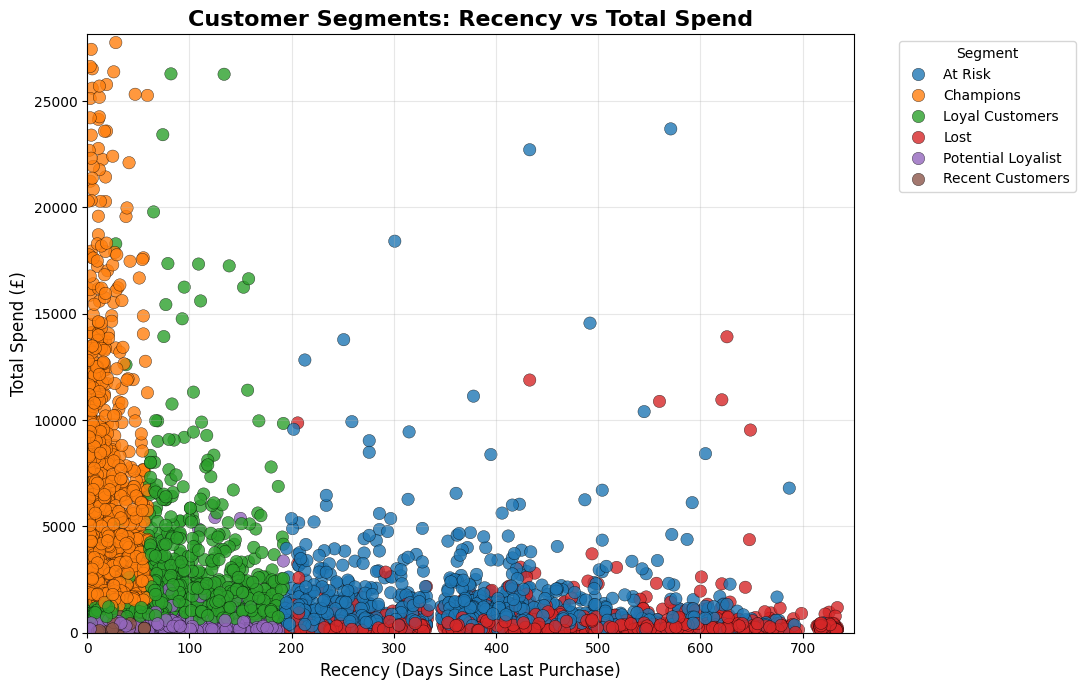

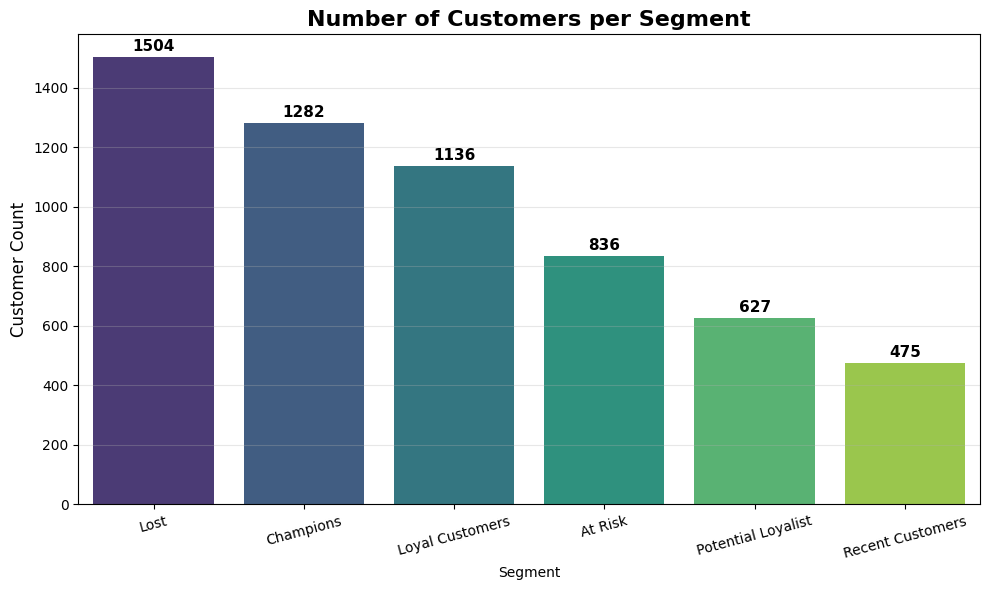


Exported: Final_RFM_Customer_Segments.csv


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 1. Scatter Plot: Recency vs Monetary by Segment
# -------------------------------------------------
plt.figure(figsize=(11, 7))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Segment',
    palette='tab10',
    s=80,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.3
)
plt.title('Customer Segments: Recency vs Total Spend', fontsize=16, fontweight='bold')
plt.xlabel('Recency (Days Since Last Purchase)', fontsize=12)
plt.ylabel('Total Spend (£)', fontsize=12)
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 750)
plt.ylim(0, rfm['Monetary'].quantile(0.99))  # Remove extreme outliers
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 2. Bar Chart: Customer Count per Segment
# -------------------------------------------------
plt.figure(figsize=(10, 6))
order = rfm['Segment'].value_counts().index
sns.countplot(data=rfm, x='Segment', order=order, palette='viridis')
plt.title('Number of Customers per Segment', fontsize=16, fontweight='bold')
plt.ylabel('Customer Count', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(rfm['Segment'].value_counts().reindex(order)):
    plt.text(i, v + 20, str(v), ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 3. Export Final RFM Table
# -------------------------------------------------
rfm.to_csv('Final_RFM_Customer_Segments.csv', index=False)
print("\nExported: Final_RFM_Customer_Segments.csv")